# Benchmark Dataset From [Kou et al., (2005)](https://projecteuclid.org/journals/annals-of-statistics/volume-34/issue-4/Equi-energy-sampler-with-applications-in-statistical-inference-and-statistical/10.1214/009053606000000515.full)
### Notebook

---

In [1]:
using Revise, DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Plots, ProgressMeter
using Distributions, MCMCChains, Random
using Optim

ProgressMeter.ijulia_behavior(:clear)
gr(fmt=:png)

Plots.GRBackend()

In [3]:
μ = [
    [2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], 
    [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], 
    [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], 
    [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.5], 
    [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]
]

Σ = [diagm(fill(0.05, 2)) for _ in eachindex(μ)]

ξ = MixtureModel(
    [MvNormal(x .- 5.0, y) for (x, y) in zip(μ, Σ)],
    fill(1 / length(μ), length(μ))
)
model = Model(ξ=ξ);

In [4]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)

gr(legendfontsize=6, levels=4, msw=0.005, lw=0.001, legend=:bottomright, axis=false, ma=0.5, msc=:firebrick1)

function plt(;lim=(-5.5, 5.5), l=200, bar=false)
    sq = range(lim..., length=l)
    contourf(sq, sq, (x, y) -> model.U([x; y]) ^ -(1+1e-1), c=cls, lw=0.1, colorbar=bar, ratio=1, grid=false)
end

function scatterplot(plt, x; kwargs...)
    p = plot(plt, x |> m2t, c=:black, lw=1, la=0.1, label="")
    p = scatter(p, x |> m2t, c=:orange; kwargs...)
end

scatterplot (generic function with 1 method)

---

## HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
  HMC(0.18394267587757893, 27, Any[]):  0.9208158368326335


Acceptance Ratio = 0.9195
 25.131054 seconds (49.41 M allocations: 3.098 GiB, 3.55% gc time, 78.78% compilation time: 0% of which was recompilation)


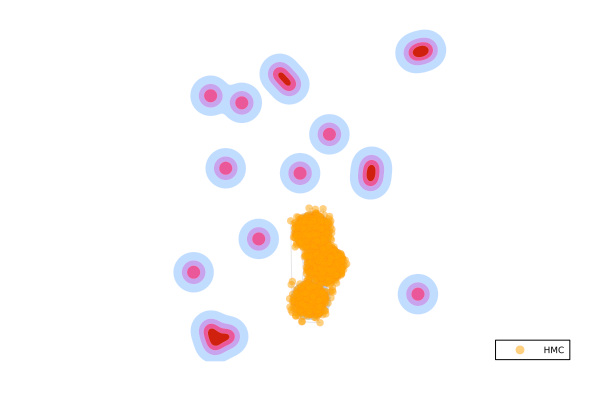

In [5]:
@time s1, a1 = mcmc(
    DualAverage(λ=5.0, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3,
    init = zeros(2)
)
x_hmc = s1[a1, :]
plt_hmc = scatterplot(plt(), x_hmc, label="HMC")

---

## RA-HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:01:35
  RAHMC(0.08373295892735858, 239, 0.20841013080856655, Any[]):  0.5736852629474105


Acceptance Ratio = 0.5775
 95.274348 seconds (445.50 M allocations: 33.136 GiB, 8.99% gc time, 1.08% compilation time)


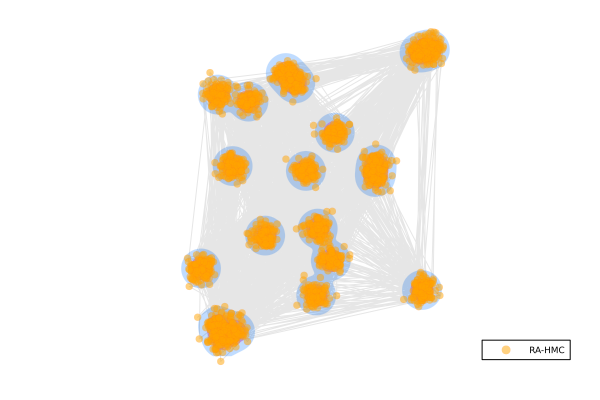

In [6]:
@time s2, a2 = mcmc(
    DualAverage(λ=20.0, δ=0.65),
    RAHMC(),
    model; n=5e3, n_burn=1e3,
    init = zeros(2)
)
x_rahmc = s2[a2, :]
plt_rahmc = scatterplot(plt(), x_rahmc |> m2t, label="RA-HMC")

---

## RAM

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  RAM(ZeroMeanIsoNormal(
dim: 2
μ: Zeros(2)
Σ: [4.0 0.0; 0.0 4.0]
)
, [1.4993750677082458, -0.16179196853756833], Any[]):       0.22079653391101484


Acceptance Ratio = 0.2215
  1.830112 seconds (6.33 M allocations: 350.218 MiB, 4.04% gc time, 64.64% compilation time)


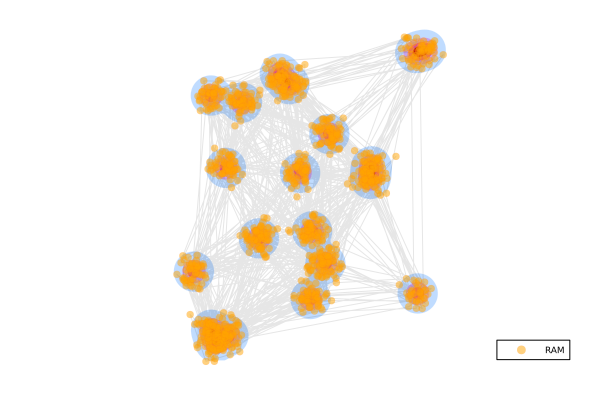

In [7]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(2, 2.0), z=randn(model.d)),
    model; n=5e3, n_burn=1e3,
    init = zeros(2)
)
x_ram = s3[a3, :]
plt_ram = scatterplot(plt(), x_ram |> m2t, label="RAM")

---

## Pseudo Extended HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:15:38
  PEHMC:  0.5671641791044776


Acceptance Ratio = 0.5098
938.757383 seconds (3.46 G allocations: 146.027 GiB, 4.11% gc time, 3.02% compilation time)


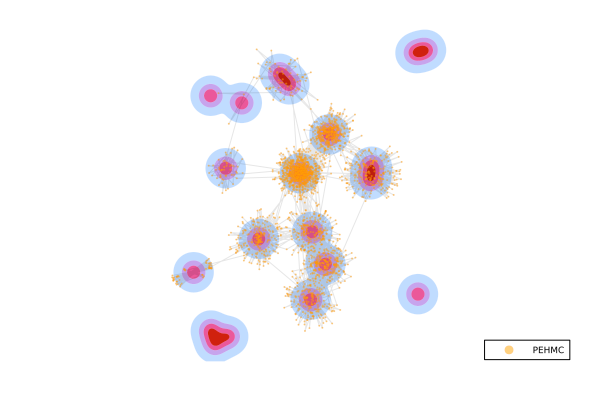

In [8]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.15, L=7, N=50),
    model; 
    n=1e2, n_burn=1e2,
    init=zeros(2)
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
plt_pehmc = scatterplot(plt(), x_pehmc |> m2t, ms=exp.(4 .* w_pehmc), label="PEHMC")

---

## Wormhole HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:05:00
  WHMC:  0.9222311075569772


Acceptance Ratio = 0.9222
300.996887 seconds (2.16 G allocations: 144.049 GiB, 9.64% gc time, 3.97% compilation time: 2% of which was recompilation)


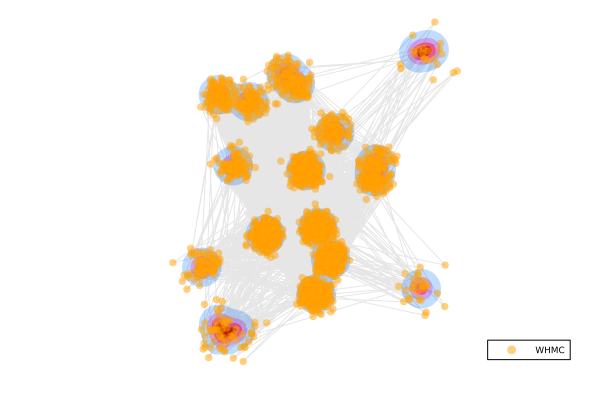

In [9]:
whmc_opt = WHMCOpt(method=LBFGS(), max_iter=100_000, temp=1.2)

@time s6, a6 = mcmc(
    WHMC(opt=whmc_opt, ϵ=0.02, L=7, k=10000), model;
    n = 5e3, n_burn=1e3
)
x_whmc = s6[a6, :];
plt_whmc = scatterplot(plt(), x_whmc |> m2t, label="WHMC")

---

## Wormhole HMC (known modes)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:19
  WHMC:  0.8428628548580568


Acceptance Ratio = 0.8429
139.698958 seconds (1.03 G allocations: 73.469 GiB, 9.44% gc time)


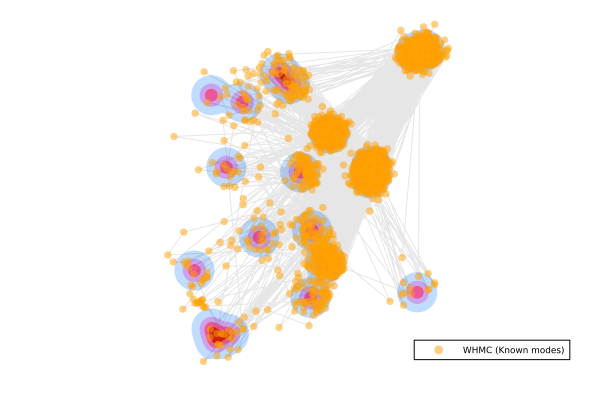

In [12]:
whmc_opt = WHMCOpt(method=LBFGS(), max_iter=100_000, temp=1.5)
whmc_sampler = WHMC(opt=whmc_opt, ϵ=0.02, L=7, modes=copy(μ), k=1000)

@time s5, a5 = mcmc(
    whmc_sampler, model;
    n=5e3, n_burn=1e3
)
x_whmc_known = s5[a5, :]
plt_whmc_known = scatterplot(plt(), x_whmc_known |> m2t, label="WHMC (Known modes)")

---

In [13]:
using StatsBase
acfplot(x; plt=nothing, kwargs...) = plot(plt, autocor(norm.(eachrow(x))); lw=2.0, la=1.0, kwargs...)

acfplot (generic function with 1 method)

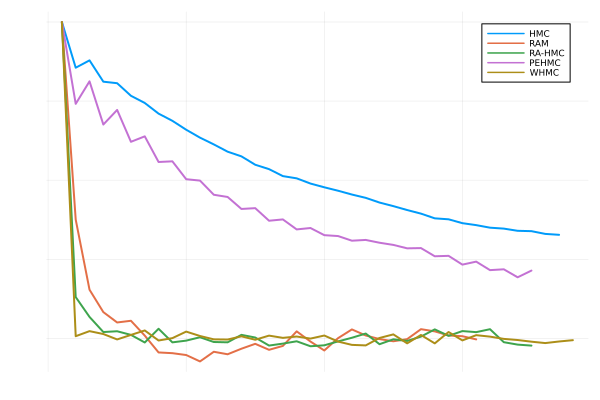

In [15]:
plt1 = acfplot(x_hmc, label="HMC", legend=:topright)
plt1 = acfplot(x_ram, plt=plt1, label="RAM")
plt1 = acfplot(x_rahmc, plt=plt1, label="RA-HMC")
plt1 = acfplot(x_pehmc, plt=plt1, label="PEHMC")
plt1 = acfplot(x_whmc, plt=plt1, label="WHMC")

---

In [16]:
function w2_minibatch(xs; eps=0.005, iters=500, k=100, N=128)
    results = zeros(length(xs))
    for (i, x) in zip(eachindex(xs), xs)
        z = Matrix(rand(model.ξ, size(x, 1))')
        results[i] = W2_minibatch(x, z, eps=eps, iters=iters, k=k, N=N)
    end
    return results
end

w2_minibatch (generic function with 1 method)

In [18]:
using Pipe
@pipe [x_hmc, x_rahmc, x_ram, x_pehmc, x_whmc] |> w2_minibatch(_)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


5-element Vector{Float64}:
 0.3371760083112819
 0.010730555242458119
 0.025274323770460703
 0.15217884713133317
 0.05143156064181731

---